In [172]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [173]:
df = pd.read_csv("fake_job_postings.csv", index_col="job_id")
df.head()

title            location  \
job_id                                                                  
1                                Marketing Intern    US, NY, New York   
2       Customer Service - Cloud Video Production      NZ, , Auckland   
3         Commissioning Machinery Assistant (CMA)       US, IA, Wever   
4               Account Executive - Washington DC  US, DC, Washington   
5                             Bill Review Manager  US, FL, Fort Worth   

       department salary_range  \
job_id                           
1       Marketing          NaN   
2         Success          NaN   
3             NaN          NaN   
4           Sales          NaN   
5             NaN          NaN   

                                          company_profile  \
job_id                                                      
1       We're Food52, and we've created a groundbreaki...   
2       90 Seconds, the worlds Cloud Video Production ...   
3       Valor Services provides Workforce Solutions th...   
4       Our passion for improving quality of life thro...   
5       SpotSource Solutions LLC is a Global Human Cap...   

                                              description  \
job_id                                                      
1       Food52, a fast-growing, James Beard Award-winn...   
2       Organised - Focused - Vibrant - Awesome!Do you...   
3       Our client, located in Houston, is actively se...   
4       THE COMPANY: ESRI – Environmental Systems Rese...   
5       JOB TITLE: Itemization Review ManagerLOCATION:...   

                                             requirements  \
job_id                                                      
1       Experience with content management systems a m...   
2       What we expect from you:Your key responsibilit...   
3       Implement pre-commissioning and commissioning ...   
4       EDUCATION: Bachelor’s or Master’s in GIS, busi...   
5       QUALIFICATIONS:RN license in the State of Texa...   

                                                 benefits  telecommuting  \
job_id                                                                     
1                                                     NaN              0   
2       What you will get from usThrough being part of...              0   
3                                                     NaN              0   
4       Our culture is anything but corporate—we have ...              0   
5                                   Full Benefits Offered              0   

        has_company_logo  has_questions employment_type required_experience  \
job_id                                                                        
1                      1              0           Other          Internship   
2                      1              0       Full-time      Not Applicable   
3                      1              0             NaN                 NaN   
4                      1              0       Full-time    Mid-Senior level   
5                      1              1       Full-time    Mid-Senior level   

       required_education                   industry              function  \
job_id                                                                       
1                     NaN                        NaN             Marketing   
2                     NaN  Marketing and Advertising      Customer Service   
3                     NaN                        NaN                   NaN   
4       Bachelor's Degree          Computer Software                 Sales   
5       Bachelor's Degree     Hospital & Health Care  Health Care Provider   

        fraudulent  
job_id              
1                0  
2                0  
3                0  
4                0  
5                0

In [174]:
df.title[-5:]

job_id
17876                     Account Director - Distribution 
17877                                   Payroll Accountant
17878    Project Cost Control Staff Engineer - Cost Con...
17879                                     Graphic Designer
17880                           Web Application Developers
Name: title, dtype: object

## Text Representation

Specifically, for each term in our dataset, we will calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf. We will use sklearn.feature_extraction.text.TfidfVectorizer to calculate a tf-idf vector for each of consumer complaint narratives:
sublinear_df is set to True to use a logarithmic form for frequency.
min_df is the minimum numbers of documents a word must be present in to be kept.
norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.
stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.

In [175]:
df.description.dropna(inplace=True)

In [176]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=480, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.title).toarray()
labels = df.fraudulent
features.shape

(17880, 26)

In [177]:
features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [178]:
feature_name = tfidf.get_feature_names()

In [179]:
title_feature = pd.DataFrame(features, columns=feature_name)

In [180]:
title_feature = title_feature.apply(np.ceil)

In [181]:
title_feature.index += 1

In [182]:
df = df.join(title_feature)

In [183]:
df.columns

Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'abroad', 'account', 'analyst', 'assistant', 'associate',
       'business', 'customer', 'customer service', 'designer', 'developer',
       'director', 'engineer', 'english', 'english teacher', 'executive',
       'manager', 'marketing', 'representative', 'sales', 'senior', 'service',
       'software', 'specialist', 'teacher', 'teacher abroad', 'web'],
      dtype='object')

In [184]:
df.description = df.description.apply(lambda x: len(str(x)))
df.drop(columns="department", inplace=True)
df.drop(columns="salary_range", inplace=True)
df.company_profile = df.company_profile.notnull().astype('int')
df.requirements = df.requirements.apply(lambda x: len(str(x)))
df.benefits = df.benefits.apply(lambda x: len(str(x)))
df.requirements.fillna(value=0, inplace=True)
df.benefits.fillna(value=0, inplace=True)
df.head()

title            location  \
job_id                                                                  
1                                Marketing Intern    US, NY, New York   
2       Customer Service - Cloud Video Production      NZ, , Auckland   
3         Commissioning Machinery Assistant (CMA)       US, IA, Wever   
4               Account Executive - Washington DC  US, DC, Washington   
5                             Bill Review Manager  US, FL, Fort Worth   

        company_profile  description  requirements  benefits  telecommuting  \
job_id                                                                        
1                     1          905           852         3              0   
2                     1         2077          1433      1292              0   
3                     1          355          1363         3              0   
4                     1         2600          1429       782              0   
5                     1         1520           757        21              0   

        has_company_logo  has_questions employment_type required_experience  \
job_id                                                                        
1                      1              0           Other          Internship   
2                      1              0       Full-time      Not Applicable   
3                      1              0             NaN                 NaN   
4                      1              0       Full-time    Mid-Senior level   
5                      1              1       Full-time    Mid-Senior level   

       required_education                   industry              function  \
job_id                                                                       
1                     NaN                        NaN             Marketing   
2                     NaN  Marketing and Advertising      Customer Service   
3                     NaN                        NaN                   NaN   
4       Bachelor's Degree          Computer Software                 Sales   
5       Bachelor's Degree     Hospital & Health Care  Health Care Provider   

        fraudulent  abroad  account  analyst  assistant  associate  business  \
job_id                                                                         
1                0     0.0      0.0      0.0        0.0        0.0       0.0   
2                0     0.0      0.0      0.0        0.0        0.0       0.0   
3                0     0.0      0.0      0.0        1.0        0.0       0.0   
4                0     0.0      1.0      0.0        0.0        0.0       0.0   
5                0     0.0      0.0      0.0        0.0        0.0       0.0   

        customer  customer service  designer  developer  director  engineer  \
job_id                                                                        
1            0.0               0.0       0.0        0.0       0.0       0.0   
2            1.0               1.0       0.0        0.0       0.0       0.0   
3            0.0               0.0       0.0        0.0       0.0       0.0   
4            0.0               0.0       0.0        0.0       0.0       0.0   
5            0.0               0.0       0.0        0.0       0.0       0.0   

        english  english teacher  executive  manager  marketing  \
job_id                                                            
1           0.0              0.0        0.0      0.0        1.0   
2           0.0              0.0        0.0      0.0        0.0   
3           0.0              0.0        0.0      0.0        0.0   
4           0.0              0.0        1.0      0.0        0.0   
5           0.0              0.0        0.0      1.0        0.0   

        representative  sales  senior  service  software  specialist  teacher  \
job_id                                                                          
1                  0.0    0.0     0.0      0.0       0.0         0.0      0.0   
2                  0.0    0.0     0.0      1.0   

In [185]:
df.drop(columns="title", inplace=True)
df.head()

location  company_profile  description  requirements  \
job_id                                                                   
1         US, NY, New York                1          905           852   
2           NZ, , Auckland                1         2077          1433   
3            US, IA, Wever                1          355          1363   
4       US, DC, Washington                1         2600          1429   
5       US, FL, Fort Worth                1         1520           757   

        benefits  telecommuting  has_company_logo  has_questions  \
job_id                                                             
1              3              0                 1              0   
2           1292              0                 1              0   
3              3              0                 1              0   
4            782              0                 1              0   
5             21              0                 1              1   

       employment_type required_experience required_education  \
job_id                                                          
1                Other          Internship                NaN   
2            Full-time      Not Applicable                NaN   
3                  NaN                 NaN                NaN   
4            Full-time    Mid-Senior level  Bachelor's Degree   
5            Full-time    Mid-Senior level  Bachelor's Degree   

                         industry              function  fraudulent  abroad  \
job_id                                                                        
1                             NaN             Marketing           0     0.0   
2       Marketing and Advertising      Customer Service           0     0.0   
3                             NaN                   NaN           0     0.0   
4               Computer Software                 Sales           0     0.0   
5          Hospital & Health Care  Health Care Provider           0     0.0   

        account  analyst  assistant  associate  business  customer  \
job_id                                                               
1           0.0      0.0        0.0        0.0       0.0       0.0   
2           0.0      0.0        0.0        0.0       0.0       1.0   
3           0.0      0.0        1.0        0.0       0.0       0.0   
4           1.0      0.0        0.0        0.0       0.0       0.0   
5           0.0      0.0        0.0        0.0       0.0       0.0   

        customer service  designer  developer  director  engineer  english  \
job_id                                                                       
1                    0.0       0.0        0.0       0.0       0.0      0.0   
2                    1.0       0.0        0.0       0.0       0.0      0.0   
3                    0.0       0.0        0.0       0.0       0.0      0.0   
4                    0.0       0.0        0.0       0.0       0.0      0.0   
5                    0.0       0.0        0.0       0.0       0.0      0.0   

        english teacher  executive  manager  marketing  representative  sales  \
job_id                                                                          
1                   0.0        0.0      0.0        1.0             0.0    0.0   
2                   0.0        0.0      0.0        0.0             0.0    0.0   
3                   0.0        0.0      0.0        0.0             0.0    0.0   
4                   0.0        1.0      0.0        0.0             0.0    0.0   
5                   0.0        0.0      1.0        0.0             0.0    0.0   

        senior  service  software  specialist  teacher  teacher abroad  web  
job_id                                                                       
1          0.0      0.0       0.0         0.0      0.0             0.0  0.0  
2          0.0      1.0       0.0         0.0      0.0             0.0  0.0  
3          0.0      0.0       0.0         0.0      0.0             0.0  0.0  
4          0.0  

In [186]:
X = df.drop(columns="fraudulent")
y = df.fraudulent

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14304, 39), (3576, 39), (14304,), (3576,))

In [187]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [188]:
df.columns

Index(['location', 'company_profile', 'description', 'requirements',
       'benefits', 'telecommuting', 'has_company_logo', 'has_questions',
       'employment_type', 'required_experience', 'required_education',
       'industry', 'function', 'fraudulent', 'abroad', 'account', 'analyst',
       'assistant', 'associate', 'business', 'customer', 'customer service',
       'designer', 'developer', 'director', 'engineer', 'english',
       'english teacher', 'executive', 'manager', 'marketing',
       'representative', 'sales', 'senior', 'service', 'software',
       'specialist', 'teacher', 'teacher abroad', 'web'],
      dtype='object')

In [192]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling="robust"), ["description", "requirements", "benefits"]),
    ('categoric', cat_pipe(encoder='onehot'), ["location", "company_profile", 
                                               "telecommuting", "has_company_logo",
                                               "has_questions", "employment_type", 
                                               "required_experience", "required_education", 
                                               "industry", "function", 
                                               'abroad', 'account', 'analyst',
       'assistant', 'associate', 'business', 'customer', 'customer service',
       'designer', 'developer', 'director', 'engineer', 'english',
       'english teacher', 'executive', 'manager', 'marketing',
       'representative', 'sales', 'senior', 'service', 'software',
       'specialist', 'teacher', 'teacher abroad', 'web']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])

model_SVC = GridSearchCV(pipeline, gsp.svm_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
model_SVC.fit(X_train, y_train)

print(model_SVC.best_params_)
print(model_SVC.score(X_train, y_train), model_SVC.best_score_, model_SVC.score(X_test, y_test))

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:  5.7min finished
/opt/anaconda3/envs/jcopml/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'algo__C': 100.0, 'algo__gamma': 0.1}
0.9665480427046264 0.7360313170800108 0.7543859649122807


## try only using top 10

In [193]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling="robust"), ["description", "requirements", "benefits"]),
    ('categoric', cat_pipe(encoder='onehot'), ["location", "company_profile", 
                                               "telecommuting", "has_company_logo",
                                               "has_questions", "employment_type", 
                                               "required_experience", "required_education", 
                                               "industry", "function", 
                                               'customer', 'developer',
                                               'engineer', 'english', 
                                               'manager', 'marketing', 
                                               'sales', 'senior',
                                               'service', 'teacher']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])

model_SVC_2 = GridSearchCV(pipeline, gsp.svm_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
model_SVC_2.fit(X_train, y_train)

print(model_SVC_2.best_params_)
print(model_SVC_2.score(X_train, y_train), model_SVC_2.best_score_, model_SVC_2.score(X_test, y_test))

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:  3.7min finished
/opt/anaconda3/envs/jcopml/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'algo__C': 10.0, 'algo__gamma': 0.1}
0.9679715302491102 0.7066246292689756 0.7514792899408284


In [194]:
mean_score_decrease(X_train, y_train, model_SVC, plot=False, topk=None, n_fold=5, normalize=False, random_state=42)

feature  importance     stdev
0              location    0.251349  0.008364
1       company_profile    0.235850  0.006903
11             industry    0.142225  0.006115
2           description    0.114835  0.008028
6      has_company_logo    0.089293  0.007410
4              benefits    0.080781  0.003810
3          requirements    0.078159  0.006042
7         has_questions    0.076643  0.004924
12             function    0.072847  0.002155
9   required_experience    0.046159  0.004147
10   required_education    0.044565  0.004656
8       employment_type    0.042008  0.004299
22            developer    0.023903  0.003043
28              manager    0.017590  0.001111
24             engineer    0.013964  0.002902
31                sales    0.011938  0.001345
5         telecommuting    0.010732  0.001466
30       representative    0.010171  0.002068
16            assistant    0.008998  0.001541
29            marketing    0.008487  0.001016
15              analyst    0.007447  0.001373
21             designer    0.006872  0.001924
32               senior    0.006400  0.000625
19             customer    0.006113  0.001409
17            associate    0.005934  0.001069
27            executive    0.005543  0.000583
34             software    0.004714  0.001149
38                  web    0.003723  0.001203
33              service    0.003635  0.001759
35           specialist    0.003501  0.001183
36              teacher    0.003050  0.001531
18             business    0.002942  0.000815
20     customer service    0.002170  0.001180
23             director    0.002084  0.000532
26      english teacher    0.001071  0.001346
14              account    0.001060  0.000337
25              english    0.001011  0.000731
13               abroad    0.000186  0.000846
37       teacher abroad   -0.000237  0.000856

feature  importance     stdev
0              location    0.251349  0.008364
1       company_profile    0.235850  0.006903
11             industry    0.142225  0.006115
2           description    0.114835  0.008028
6      has_company_logo    0.089293  0.007410
4              benefits    0.080781  0.003810
3          requirements    0.078159  0.006042
7         has_questions    0.076643  0.004924
12             function    0.072847  0.002155
9   required_experience    0.046159  0.004147
10   required_education    0.044565  0.004656
8       employment_type    0.042008  0.004299

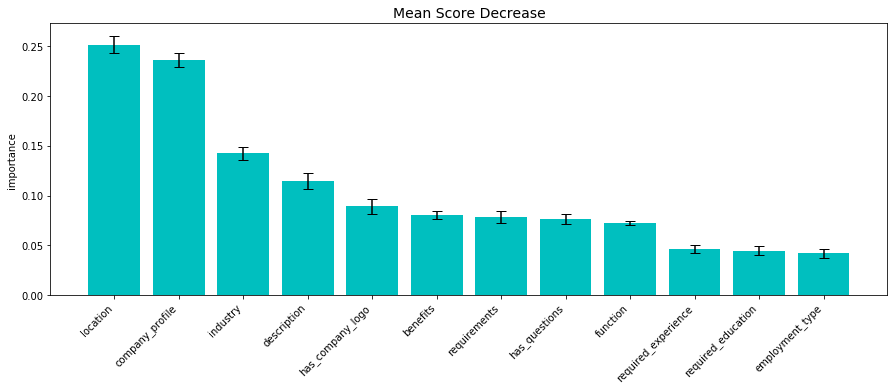

In [196]:
mean_score_decrease(X_train, y_train, model_SVC, plot=True, topk=12, n_fold=5, normalize=False, random_state=42)